In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from collections import namedtuple
from itertools import combinations, product

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import StratifiedKFold, cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              AdaBoostClassifier,
                              ExtraTreesClassifier)

from myhelper import extract_column_names, sampling, data_prep
from myconfig import TARGET_COL

warnings.filterwarnings('ignore')


## Objective
In this notebook I will present a configurable benchmark to evaluate predictions based on different approaches:<br>
This will allow us to determine which set of methods seem to work best. I will be using a cross-validation approach to assess the predictions of each method.<br>

Each method is a combination of the following parameters

. use of different set of feature engineering columns<br>
. data power transformation<br>
. data scaling <br>
. use of different tree-based models<br>


## helper

In [2]:
def _benchmark(X, y, models, scale_cols, scoring, apply_power_tf=False, apply_scaler_tf=False, apply_pca=False, test_mode=True):

    results = {}
    steps = []

    # test mode for quick workflow check
    if test_mode:
        sample_size = 100
        idx = np.random.choice(range(0, len(X)), sample_size, False)
        X = X.loc[idx, :].copy()
        y = y[idx].copy()

    # apply column transformation
    if apply_scaler_tf and scale_cols is not None and len(scale_cols) > 0:
        transformers = []
        # apply power transformation
        if apply_power_tf:
            transformers.append(('power_tf', PowerTransformer(method='yeo-johnson', standardize=False), scale_cols))
        
        # apply standardization
        transformers.append(('scaler_tf', StandardScaler(), scale_cols))
        # add step to pipeline
        steps.append(('data_tf', ColumnTransformer(transformers=transformers, remainder='passthrough')))

    # apply feature selection
#     ('selction', SelectKBest(chi2, k = 10))
    
    # apply feature reduction with pca
    if apply_pca:
        steps.append(('pca', PCA(n_components=0.6)))

    # define cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

    # evaluate model performence
    for name, model in models.items():
        # create pipeline
        pipeline = Pipeline(steps + [('classifier', model)])
        results[name] = cross_val_score(pipeline, X, y, scoring=scoring, n_jobs=-1, cv=cv)    
    
    results = pd.DataFrame.from_dict(results)
    return results

def run_benchmark(X, y, config, models, scoring='roc_auc', test_mode=0, verbose=0):

    res = []
    for i, config in enumerate(generate_combinations(config)):
        # informative purposes
        if verbose:
            print(config)
        # extracting column names
        cols = []
        for prefix in config.col_prefix:
            cols.extend(extract_column_names(X, prefix))
        # benchmarking
        scale_cols = extract_column_names(X[cols], '^(?!{})'.format(config.exclude_to_scale))
        res_ = _benchmark(models=models,
                          X=X[cols],
                          y=y,
                          scoring=scoring,
                          scale_cols=scale_cols,              
                          apply_power_tf=config.power_tf,
                          apply_scaler_tf=config.scaler_tf,
                          apply_pca=config.pca,
                          test_mode=test_mode)
        # adding extra info
        res_['col_prefix'] = str(config.col_prefix)
        res_['has_power_tf'] = config.power_tf
        res_['has_scaler_tf'] = config.scaler_tf
        res_['has_pca'] = config.pca

        # append to final benchmark results
        res.append(res_)

    ans = pd.DataFrame()
    for elem in res:
        ans = pd.concat([ans, elem], axis=0)

    return ans

def generate_combinations(config):
    def combinations_(config):
        combis = []
        for i in range(1, len(config['col_prefix'])+1):
            combis.extend(combinations(config['col_prefix'], i))

        return (product(combis, config['power_tf'], config['scaler_tf'], config['pca']))

    # return generator of named tuple
    Config = namedtuple('Config', ['col_prefix', 'power_tf', 'scaler_tf', 'pca', 'exclude_to_scale'])

    for elem in combinations_(config):
        yield Config(col_prefix=elem[0],
                     power_tf=elem[1],
                     scaler_tf=elem[2],
                     pca=elem[3],
                     exclude_to_scale=config['exclude_to_scale'])

def plot_perf(df):
    agg_cols = ['col_prefix', 'has_power_tf', 'has_scaler_tf', 'has_pca']
    agg = df.groupby(agg_cols).agg(['mean', 'std'])
    agg.columns = ['_'.join(col).strip() for col in agg.columns.values]

    # plot mean
    agg = agg[extract_column_names(agg, '_mean$')].fillna(0)
    agg.columns = [col.replace('_mean', '') for col in agg.columns]
    agg = agg.sort_values(agg.columns[0], ascending=False)
    g = sns.heatmap(agg, cmap='YlGnBu', annot=True, square=False, linewidths=.5,
                    fmt='.5f', annot_kws={'fontsize':12})
    g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12)
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)   
    plt.show();


In [4]:
models = {
          'lgb': LGBMClassifier(),
          'xgboost': XGBClassifier(),
          'RF': RandomForestClassifier(),
          'Adaboost': AdaBoostClassifier(),
          'extratree': ExtraTreesClassifier()
}

# config = {'col_prefix': ['fe0__', 'fe1__', 'fe2__'],   
#            'power_tf': [0,1],
#            'scaler_tf': [0,1],
#            'pca': [0],
#            'exclude_to_scale': 'fe2__'
# }

config = {'col_prefix': ['fe0__', 'fe1__', 'fe2__'],   
          'power_tf': [0,1],
          'scaler_tf': [0,1],
          'pca': [0,1],
          'exclude_to_scale': 'fe2__'
         }


In [5]:
scoring='roc_auc'
test_mode = 0
verbose = 1

# data prep
df = pd.read_csv('data/train.csv').pipe(data_prep)
X, y = df.drop(columns=TARGET_COL), df[TARGET_COL]

# run benchmark
perf = run_benchmark(X=X,
                     y=y,
                     config=config,
                     models=models,
                     scoring=scoring,
                     test_mode=test_mode,
                     verbose=verbose)
print('done')

Config(col_prefix=('fe0__',), power_tf=0, scaler_tf=0, pca=0, exclude_to_scale='fe2__')
Config(col_prefix=('fe0__',), power_tf=0, scaler_tf=0, pca=1, exclude_to_scale='fe2__')
Config(col_prefix=('fe0__',), power_tf=0, scaler_tf=1, pca=0, exclude_to_scale='fe2__')
Config(col_prefix=('fe0__',), power_tf=0, scaler_tf=1, pca=1, exclude_to_scale='fe2__')
Config(col_prefix=('fe0__',), power_tf=1, scaler_tf=0, pca=0, exclude_to_scale='fe2__')
Config(col_prefix=('fe0__',), power_tf=1, scaler_tf=0, pca=1, exclude_to_scale='fe2__')
Config(col_prefix=('fe0__',), power_tf=1, scaler_tf=1, pca=0, exclude_to_scale='fe2__')
Config(col_prefix=('fe0__',), power_tf=1, scaler_tf=1, pca=1, exclude_to_scale='fe2__')
Config(col_prefix=('fe1__',), power_tf=0, scaler_tf=0, pca=0, exclude_to_scale='fe2__')
Config(col_prefix=('fe1__',), power_tf=0, scaler_tf=0, pca=1, exclude_to_scale='fe2__')
Config(col_prefix=('fe1__',), power_tf=0, scaler_tf=1, pca=0, exclude_to_scale='fe2__')
Config(col_prefix=('fe1__',), po

In [6]:
# saving scores
perf.to_csv('data/perf-results.csv', index=False);

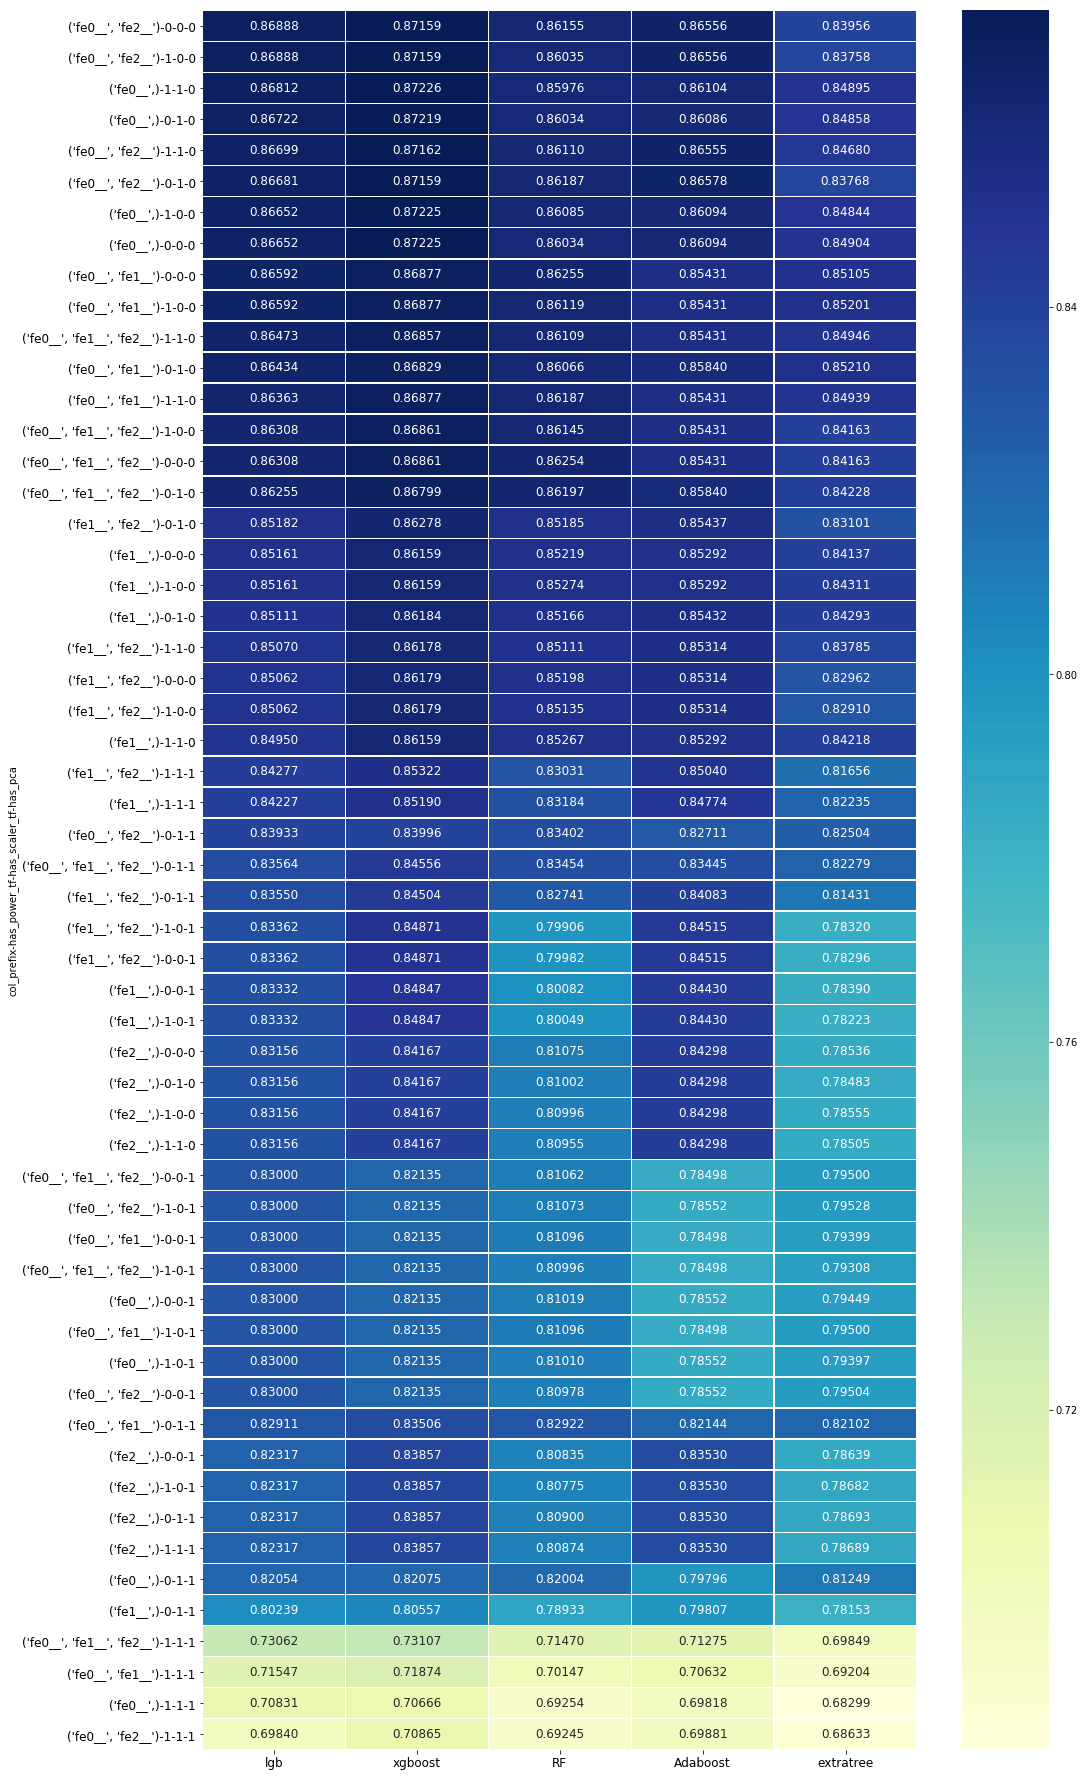

In [12]:
plt.figure(figsize=(16,32));
plot_perf(perf)

### Takeaway
&emsp;. Best scores don't include PCA<br>
&emsp;. Best scores can be achieve with no feature engineering / no data transformation<br>
&emsp;. In the next section I will perform hyper-tuning on the best combinations found in this notebook